In [62]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating environment at `~/桌面/optimal-control-homework/HW1_S24-main/Project.toml`


# Q2 (30 pts): Augmented Lagrangian Quadratic Program Solver

## Part (A): QP Solver (10 pts)
Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [63]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:

as long as solve_qp works. 
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    
    inequ=h_ineq(qp,x)
    length=size(inequ)[1]
    mask=zeros(length,length)
    for i=1:length
        
        if inequ[i]<0 && μ[i]==0
            mask[i,i]=0
        else
            
            mask[i,i]=ρ
        end
        
    end
    
    return mask
    
    
end
function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    
    L(x,λ,μ)=cost(qp,x)+λ'*c_eq(qp,x)+μ'*h_ineq(qp,x)
    Iρ=mask_matrix(qp,x,μ,ρ)
    return L(x,λ,μ)+0.5*ρ*norm(c_eq(qp,x))^2+0.5*h_ineq(qp,x)'*Iρ*h_ineq(qp,x)
  
end
function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm
    stationarity_norm = norm(qp.Q*x+qp.q+(qp.A)'*λ+(qp.G)'*μ) # fill this in 
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    ρ=1.0
    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    
    # TODO:
    for main_iter = 1:max_iters
        
        stationarity_norm = norm(qp.Q*x+qp.q+(qp.A)'*λ+(qp.G)'*μ)
        
        L(x)=augmented_lagrangian(qp,x,λ,μ, ρ)
        al_grandient=FD.gradient(L,x)
        for i=1:100
            al_grandient=FD.gradient(L,x)
            if norm(al_grandient)<1e-6
                λ=λ+ρ*c_eq(qp,x)
                μ=max.(0,μ+ρ*h_ineq(qp,x))
                ρ=ρ*10.0
                break
            else
                h=FD.hessian(L,x)
                x=x-h\al_grandient
            end
            
        end
        
        if verbose
            logging(qp, main_iter, al_grandient, x, λ, μ, ρ)
        end
        if stationarity_norm<tol && norm(c_eq(qp,x),Inf)<tol && abs(dot(μ,h_ineq(qp,x)))<tol
                return x, λ, μ
        end

      
        

         
        

                
        
    end
    error("qp solver did not converge")
end
let 
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-8)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.57e-15   6.20e-15   5.51e-01   1.27e+00   4.59e-01  1e+01
  2   6.16e+00   4.06e-14   2.56e-02   3.07e-01   1.05e-02  1e+02
  3   5.52e-01   1.48e-13   6.84e-03   1.35e-02   7.94e-03  1e+03
  4   4.06e-12   4.06e-12   3.64e-05   1.62e-04   1.06e-04  1e+04
  5   2.15e-11   2.15e-11  -5.61e-09   2.05e-08   1.14e-08  1e+05
  6   4.22e-10   4.22e-10  -1.58e-13   3.92e-13   1.89e-13  1e+06


([-0.3262308057134029, 0.24943797997188877, -0.4322676644050713, -1.4172246971241345, -1.3994527400876546, 0.6099582408523683, -0.07312202122159459, 1.3031477521999637, 0.5389034791065495, -0.7225813651685942], [-0.12835195124671872, -2.8376241673520726, -0.8320804499706393], [0.03635294259840549, 0.0, 0.0, 1.059444495112555, 0.0])

### QP Solver test

In [64]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.57e-15   6.20e-15   5.51e-01   1.27e+00   4.59e-01  1e+01
  2   6.16e+00   4.06e-14   2.56e-02   3.07e-01   1.05e-02  1e+02
  3   5.52e-01   1.48e-13   6.84e-03   1.35e-02   7.94e-03  1e+03
  4   4.06e-12   4.06e-12   3.64e-05   1.62e-04   1.06e-04  1e+04
  5   2.15e-11   2.15e-11  -5.61e-09   2.05e-08   1.14e-08  1e+05
Test Summary: | Pass  Total
qp solver     |    3      3


Test.DefaultTestSet("qp solver", Any[], 3, false, false)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \mu \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\mu \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \mu_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\mu_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\mu_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (B): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**

## Part (C): Brick Simulation (5 pts)

In [65]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    
    qp = (
        Q = [mass 0; 0 mass], 
        q = [mass 0; 0 mass]*(Δt*[0; 9.81] - v),
        A = zeros(0,2),
        b = zeros(0),   
        G = -[0 Δt],
        h = [0 1] * q
    )
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [66]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 -.01]) < 1e-10 
    @test abs(qp.h[1] -3) < 1e-10
    
end

Test Summary: | Pass  Total
brick qp      |   10     10


Test.DefaultTestSet("brick qp", Any[], 10, false, false)

#= In[67]:30 =# @test(abs(maximum(ys) - 2) < 0.1) = Test Passed
#= In[67]:31 =# @test(minimum(ys) > -0.01) = Test Passed
#= In[67]:32 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed
#= In[67]:35 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= In[67]:36 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= In[67]:37 =# @test(ys[110] > 0.01) = Test Passed
#= In[67]:38 =# @test(abs(ys[111]) < 0.01) = Test Passed
#= In[67]:39 =# @test(abs(ys[112]) < 0.01) = Test Passed


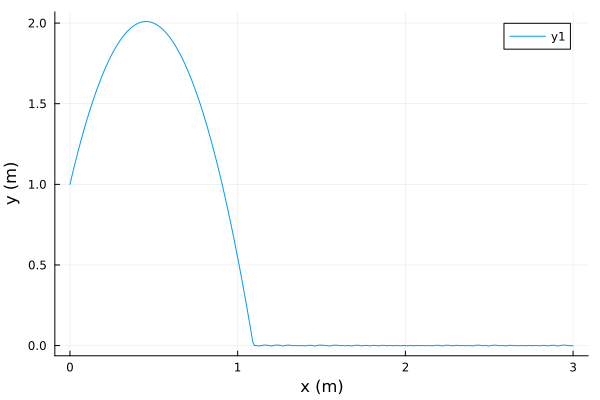

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8710


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8710))

In [67]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for k =1:N-1
        qp = brick_simulation_qp(qs[k],vs[k])
        vs[k+1],_,_=solve_qp(qp; verbose = false, tol = 1e-4)
        qs[k+1] = qs[k] + dt*vs[k+1]
    end
        

    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end

# Part D (5 pts): Solve a QP

Use your QP solver to solve the following optimization problem:


$$
\begin{align} 
\min_{y\in\mathbb{R}^2,a\in\mathbb{R},b\in\mathbb{R}} \quad & \frac{1}{2}y^T \begin{bmatrix} 1 & .3 \\ .3 & 1 \end{bmatrix} y + a^2 + 2b^2  + \begin{bmatrix} -2 & 3.4 \end{bmatrix} y + 2a + 4b \\ 
\text{st} \quad & a + b = 1 \\ 
& \begin{bmatrix}-1 & 2.3 \end{bmatrix} y + a - 2b =3 \\
& -0.5 \leq y \leq 1 \\ 
& -1 \leq a \leq 1 \\ 
& -1 \leq b \leq 1
\end{align}
$$

You should be able to put this into our standard QP form that we used above, and solve.

In [ ]:
@testset "part D" begin

    y = randn(2)
    a = randn()
    b = randn()
    
    
    @test norm(y - [-0.080823; 0.834424]) < 1e-3 
    @test abs(a - 1) < 1e-3 
    @test abs(b) < 1e-3 
end

## Part E (5 pts): One sentence short answer

1. For our Augmented Lagrangian solver, if our initial guess for $x$ is feasible (meaning it satisfies the constraints), will it stay feasible through each iteration? 

**put ONE SENTENCE answer here**

2. Does the Augmented Lagrangian function for this problem always have continuous first derivatives?

**put ONE SENTENCE answer here** 

3. Is the QP in part D always convex?

**put ONE SENTENCE answer here**